In [87]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms 

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [89]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [90]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [91]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [94]:
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# The ImageNet datset does not contain any x-ray images and the size of the current dataset is also large

train_dir = 'datasets/chest_xray/train'
test_dir = 'datasets/chest_xray/test'

In [95]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

In [96]:
train_data

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: datasets/chest_xray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [97]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                           shuffle=True)

In [98]:
test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform)

In [99]:
test_data

Dataset ImageFolder
    Number of datapoints: 624
    Root location: datasets/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [100]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                          shuffle=True)

In [101]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [102]:
class_names = train_data.classes

print(class_names)

['NORMAL', 'PNEUMONIA']


In [103]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)

In [104]:
inputs, classes = next(iter(dataloaders['train']))

In [105]:
out = torchvision.utils.make_grid(inputs)

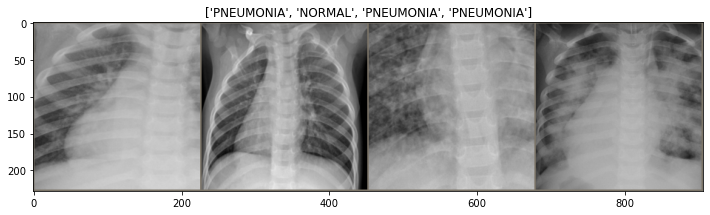

In [106]:
imshow(out, title=[class_names[x] for x in classes])

## Load AlexNet

In [110]:
from torchvision import models

# Retain the architecture but not the initial weights of the model - the model will be initialized with random weights
model = models.alexnet()

In [111]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [112]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [113]:
model.classifier[6] = nn.Linear(num_ftrs, 2)

In [114]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [115]:
criterion   = nn.CrossEntropyLoss()

optimizer   = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [116]:
def train_model(model, criterion, optimizer, num_epochs=25):

    model = model.to(device)
    total_step = len(dataloaders['train'])


    for epoch in range(num_epochs):
        print('epoch =',epoch)        

        for i, (images,labels)  in enumerate((dataloaders['train'])):

                images = images.to(device)
                labels = labels.to(device)
    
                outputs = model(images)
                outputs = outputs.to(device)
                loss = criterion(outputs,labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        print('Epoch - %d, loss - %0.5f '\
            %(epoch, loss.item()))

    return model

In [117]:
model = train_model(model, criterion, optimizer, num_epochs=10)

epoch= 0
Epoch [1/10], Step [100/1304], Loss: 0.6032
Epoch [1/10], Step [200/1304], Loss: 0.5667
Epoch [1/10], Step [300/1304], Loss: 0.4019
Epoch [1/10], Step [400/1304], Loss: 0.3389
Epoch [1/10], Step [500/1304], Loss: 0.7823
Epoch [1/10], Step [600/1304], Loss: 0.4818
Epoch [1/10], Step [700/1304], Loss: 0.7704
Epoch [1/10], Step [800/1304], Loss: 1.0742
Epoch [1/10], Step [900/1304], Loss: 0.5557
Epoch [1/10], Step [1000/1304], Loss: 0.4094
Epoch [1/10], Step [1100/1304], Loss: 0.1712
Epoch [1/10], Step [1200/1304], Loss: 0.4180
Epoch [1/10], Step [1300/1304], Loss: 0.5396
Epoch - 0, loss - 0.51574 
epoch= 1
Epoch [2/10], Step [100/1304], Loss: 0.1089
Epoch [2/10], Step [200/1304], Loss: 0.9651
Epoch [2/10], Step [300/1304], Loss: 0.5521
Epoch [2/10], Step [400/1304], Loss: 0.6290
Epoch [2/10], Step [500/1304], Loss: 0.2033
Epoch [2/10], Step [600/1304], Loss: 0.3473
Epoch [2/10], Step [700/1304], Loss: 0.1909
Epoch [2/10], Step [800/1304], Loss: 0.4700
Epoch [2/10], Step [900/130

In [118]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [119]:
with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the test images: 89.42307692307692%


Acutal label 0


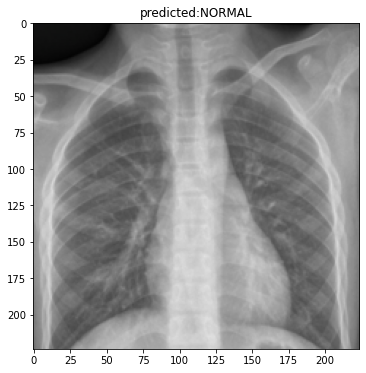

Acutal label 1


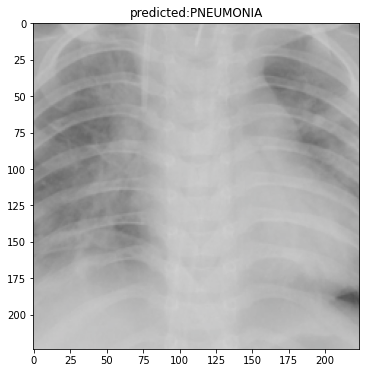

Acutal label 0


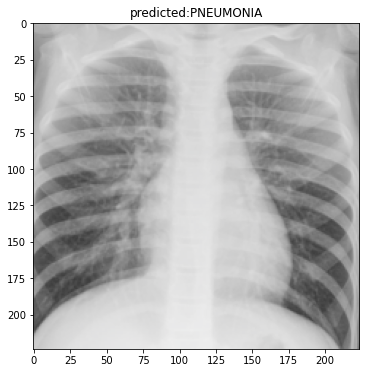

Acutal label 0


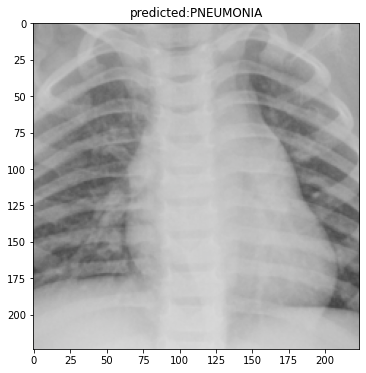

In [120]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        print ("Acutal label", np.array(labels)[j])
        
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])